In [83]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support  # Importar las métricas necesarias
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn
from data_cleaning import clean_text, clean_df, preprocess_text, preprocess_df, insert_type_cols, delete_words, delete_words_df

In [67]:
from bert_embeddings import get_bert_embeddings

In [69]:
df = pd.read_csv("data/data_no_id.csv", header=0)

df_clean = clean_df(df)
#df_prep = preprocess_df(df_clean)
df_prep = delete_words_df(df_clean)
df_complete = insert_type_cols(df_prep)

In [71]:
df_especific = df_complete[df_complete.type_general == "other"]

### Clasificación

In [77]:
X = np.vstack(df_especific.message.apply(get_bert_embeddings))
y = df_especific['type_especific']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state=42)

from collections import Counter
print(Counter(y_train))

Counter({'cause': 34, 'other': 27, 'diagnosis': 24, 'prognosis': 20, 'symptom': 16, 'organization': 16, 'indication': 15, 'susceptibility': 12, 'association': 8})


In [81]:
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [63]:
# Inicia una nueva ejecución en MLflow
# Configuración de MLflow
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('especific_classification')
with mlflow.start_run():
    # Parámetros del modelo
    n_estimators = 100
    class_weight = 'balanced'
    
    # Registrar parámetros
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_param('class_weight', class_weight)
    
    # Entrena el modelo
    especific_classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight=class_weight, random_state=42)#class_weight=class_weight, random_state=100)
    especific_classifier.fit(X_train_smote, y_train_smote)
    y_pred = especific_classifier.predict(X_test)

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Registrar métricas
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('f1_score', f1)

    # Registrar el modelo
    mlflow.sklearn.log_model(especific_classifier, 'random_forest_model')


# Evaluar el rendimiento
print(classification_report(y_test, y_pred))
print(f"Exactitud: {accuracy_score(y_test, y_pred)}")


accuracy = accuracy_score(y_test, y_pred)


C:\Users\anton\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024/07/29 19:34:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/07/29 19:34:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run tasteful-bear-429 at: http://localhost:5000/#/experiments/997033071663245475/runs/70336544c98f43598b9dcc417ad256ab.
2024/07/29 19:34:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/997033071663245475.


                precision    recall  f1-score   support

   association       0.00      0.00      0.00         1
         cause       0.25      0.17      0.20         6
     diagnosis       0.60      0.75      0.67         4
    indication       1.00      0.33      0.50         3
  organization       0.60      1.00      0.75         3
         other       0.25      0.20      0.22         5
     prognosis       0.33      0.25      0.29         4
susceptibility       0.00      0.00      0.00         2
       symptom       0.29      0.67      0.40         3

      accuracy                           0.39        31
     macro avg       0.37      0.37      0.34        31
  weighted avg       0.39      0.39      0.36        31

Exactitud: 0.3870967741935484


C:\Users\anton\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anton\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anton\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
import joblib

# Guardar el modelo en un archivo
joblib.dump(especific_classifier, 'random_forest_especific_classifier.pkl')


['random_forest_especific_classifier.pkl']

Matriz de confusión:
[[0 1 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 1]
 [0 1 2 0 0 0 1 0 0]
 [0 1 0 0 0 1 1 0 0]
 [0 1 0 0 2 0 0 0 0]
 [0 2 1 0 0 1 0 0 1]
 [0 0 0 0 0 0 3 0 1]
 [0 0 0 1 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 2]]


Text(0.5, 1.0, 'Matriz de Confusión')

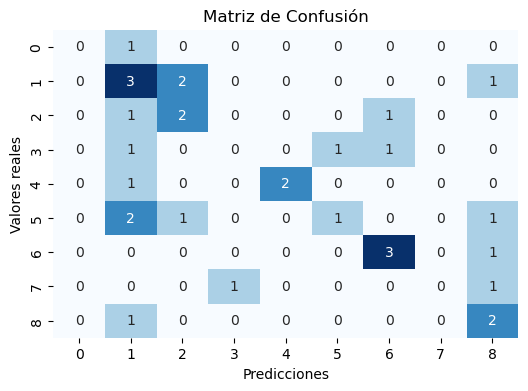

In [33]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Imprimir la matriz
print("Matriz de confusión:")
print(confusion)

import seaborn as sns
import matplotlib.pyplot as plt

# Crear el heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión")